# Robust SVM (WORK IN PROGRESS)

Support Vector Machines (SVMs) are a set of supervised learning methods primarily used for classification. A Robust SVM is a variation of the standard SVM designed to handle data that is noisy or contains outliers more effectively. While the standard SVM focuses on finding a hyperplane that best separates classes by maximizing the margin between them, a Robust SVM aims to improve the model’s performance and stability in the presence of noise and outliers.

In this notebook, we will consider example 4.5 introduced in Ali, Kolter, Diamond, and Boyd (2015) [1]. Based on the data given, we can reformulate the optimization problem as:

$$
\begin{aligned}
& \text{minimize} \quad \frac{1}{2} \| w \|^2 + C \cdot \vec{1}^T \vec{\xi} \\
& \text{subject to:} \\
& w^T(x_i + u_x) + b \geq 1 - \xi _i\\
&  w^T (x_i + u_y) + b \geq 1 - \xi_i, \\
& \vec{\xi} \geq \vec{0}

\end{aligned}
$$

In [1]:
import numpy as np
import cvxpy as cp
import lropt
import matplotlib.pyplot as plt
from scipy.sparse import SparseEfficiencyWarning
import warnings
warnings.filterwarnings('ignore', category=UserWarning, module='cvxpy')
warnings.filterwarnings('ignore', category=SparseEfficiencyWarning)

In [2]:
np.random.seed(1)
N=2
M = 100
MU_1 = np.array([0, 0])           # Mean for class 1
SIG_1 = np.array([[1, 0.5],       # Covariance for class 1
                  [0.5, 1]])

MU_2 = np.array([3, 3])           # Mean for class 2
SIG_2 = np.array([[1, -0.7],      # Covariance for class 2
                  [-0.7, 1]])

DATA_1= np.random.multivariate_normal(MU_1, SIG_1, M)
C = 0.01

In [3]:
DATA_2= np.random.multivariate_normal(MU_2, SIG_2, M)

In [6]:
np.random.seed(1)
w = cp.Variable(N)
b = cp.Variable()
xi = cp.Variable(N)
u = lropt.UncertainParameter(N, uncertainty_set = lropt.Ellipsoidal(p = 2,rho=0.1, b = [-0.01347606, -0.01514421]))


In [7]:
objective = cp.Minimize(cp.norm2(w)**2 + C*(cp.sum(xi)))

In [8]:
constraints = []
for i in range(N):
    constraints.append(w@(DATA_1[i] + u) + b >= 1 - xi[i])
    constraints.append(-(w@(DATA_2[i]+ u) + b) >= 1 - xi[i])
    
prob = lropt.RobustProblem(objective, constraints)
prob.solve()

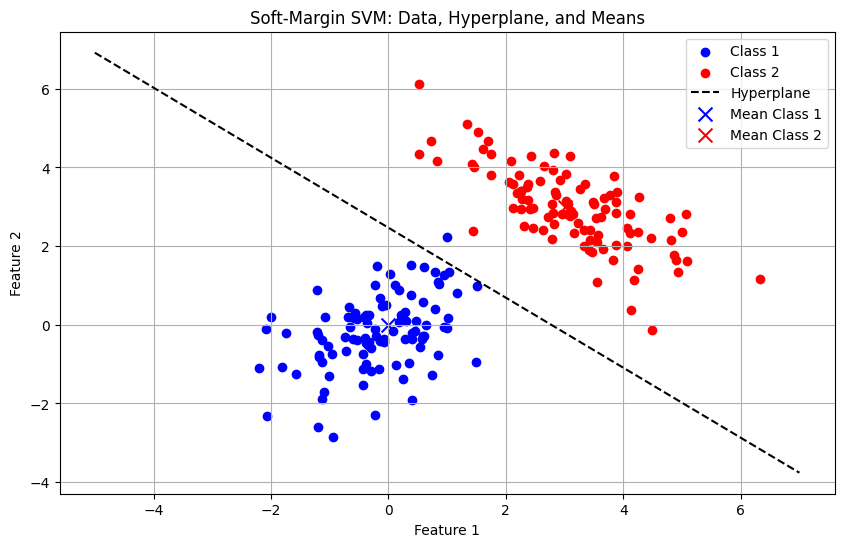

In [10]:

w_opt = w.value
b_opt = b.value


x_range = np.linspace(-5, 7, 100)  

# Calculate the hyperplane line
y_range = - (w_opt[0] * x_range + b_opt) / w_opt[1]


plt.figure(figsize=(10, 6))

plt.scatter(DATA_1[:, 0], DATA_1[:, 1], color='blue', label='Class 1')
plt.scatter(DATA_2[:, 0], DATA_2[:, 1], color='red', label='Class 2')


plt.plot(x_range, y_range, 'k--', label='Hyperplane')


plt.scatter(MU_1[0], MU_1[1], color='blue', marker='x', s=100, label='Mean Class 1')
plt.scatter(MU_2[0], MU_2[1], color='red', marker='x', s=100, label='Mean Class 2')


plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Soft-Margin SVM: Data, Hyperplane, and Means')
plt.legend()
plt.grid(True)
plt.show()

- create visualization with hyperplane
- for different values of the size of the set, show different hyperplanes

## References

1. Ali, A., Kolter, J. Z., Diamond, S., & Boyd, S. (2015). Disciplined convex stochastic programming: A new framework for stochastic optimization. Proceedings of the 31st Conference on Uncertainty in Artificial Intelligence.
